In [ ]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

In [ ]:
import fastai
from fastai import *
from fastai.text import *
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [ ]:
# from sklearn.datasets import fetch_20newsgroups
# dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))

In [ ]:
# documents = dataset.data
# type(dataset)

sklearn.utils.Bunch

In [ ]:
df = pd.read_csv('./Cleaned_tweets.csv')
df = df[['Label', 'Text']]
df.head()

,Label,Text
0,1,He’d have my phone wedged up his ass sideways.
1,0,Yep 100% agree and the same with severine in s...
2,1,Stop having sex with men that won’t eat your p...
3,1,"When you see a sad man, just give him breast t..."
4,1,We can't be together if you don't eat pussy


In [ ]:
# df = pd.DataFrame({
#     'label':dataset.target,
#     'text':dataset.data
# })
df.shape

(3604, 2)

In [ ]:
df['Label'].value_counts()

1    1973
0    1631
Name: Label, dtype: int64

In [ ]:
df.head()

,Label,Text
0,1,He’d have my phone wedged up his ass sideways.
1,0,Yep 100% agree and the same with severine in s...
2,1,Stop having sex with men that won’t eat your p...
3,1,"When you see a sad man, just give him breast t..."
4,1,We can't be together if you don't eat pussy


In [ ]:
# df = df[df['Label'].isin([1, 10])].reset_index(drop = True)

In [ ]:
df['Label'].value_counts()

1    1973
0    1631
Name: Label, dtype: int64

In [ ]:
df['Text']=df['Text'].str.replace("[^a-zA-Z]", " ")
df['Text']

0          He d have my phone wedged up his ass sideways 
1       Yep      agree and the same with severine in s...
2       Stop having sex with men that won t eat your p...
3       When you see a sad man  just give him breast t...
4             We can t be together if you don t eat pussy
                              ...                        
3599    only for a     brown hair brown eye gamer girl...
3600    Don t be suspicious  Some butt  some suggestiv...
3601               mhmmmmm i hear ya big tittie lil booty
3602          I hate dirty stank ass cowboy fans bro lmao
3603    His balls were like the eyes of the Fremen  re...
Name: Text, Length: 3604, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tokenized_doc = df['Text'].apply(lambda x: x.split())

tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['Text'] = detokenized_doc

In [ ]:
df.head()

,Label,Text
0,1,He phone wedged ass sideways
1,0,Yep agree severine skyfall I really get scenes...
2,1,Stop sex men eat pussy
3,1,When see sad man give breast suck Even strange...
4,1,We together eat pussy


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, stratify = df['Label'], test_size=0.25, random_state=12)

In [ ]:
df_train.shape, df_val.shape

((2703, 2), (901, 2))

In [ ]:
df_val.shape

(901, 2)

In [ ]:
data_lm = TextLMDataBunch.from_df(train_df=df_train, valid_df=df_val, path="")
data_clas = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df= df_val
                                      , vocab = data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
lang_mod = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.7)

In [ ]:
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,6.574220,5.032816,0.206101,00:01
1,5.720993,4.565992,0.270610,00:01
2,5.190586,4.508910,0.257366,00:01
3,4.829357,4.456260,0.270015,00:01


epoch,train_loss,valid_loss,accuracy,time
0,4.004876,4.397799,0.286905,00:01
1,3.926223,4.377149,0.283929,00:01
2,3.856771,4.362714,0.289881,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.717195,4.348639,0.294494,00:01
1,3.695430,4.359213,0.291890,00:01
2,3.689635,4.356311,0.294122,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.647024,4.359465,0.295238,00:01
1,3.600831,4.368434,0.296726,00:01
2,3.571458,4.379476,0.294494,00:01


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
xxbos xxmaj my research xxunk xxmaj xxunk stop xxunk xxup xxunk i love nerdy girls xxunk ass stop crushing xxunk xxmaj after xxunk showed ring xxunk pictures ass xxunk e xxunk xxunk xxmaj it ass xxunk xxmaj why like ass xxmaj xxunk e n r b might ass really digging xxunk first place ass xxunk xxunk e xxup rt i hate farting ass bitch shit funny ass xxunk e xxup,1
xxbos xxup without xxup feeling xxup xxunk xxup every xxup time i xxup play xxup xxunk xxup and xxup xxunk xxup the xxup dungeon i xxup xxunk xxup mute xxup it xxup and xxup put xxup on xxup my xxup own xxup music xxup because i xxup can t xxup stand xxup listening xxup to xxup her xxup bitch xxup ass xxup talk xxup without xxup my xxup head xxup,1
xxbos xxup fuck xxup being xxup good xxup im a xxup bad xxup bitch xxup im xxup sick xxup of xxup mfs xxup tryna xxup tell xxup me xxup how xxup to xxup live xxup white xxup hoes xxup hate xxup under xxup my xxup pictures xxup on xxup the xxup gram xxup bitch u xxup better xxup hope i xxup never xxup run xxup across xxup ur xxup man,0
xxbos fuck xxup being xxup good xxup im a xxup bad xxup bitch xxup im xxup sick xxup of xxup mfs xxup tryna xxup tell xxup me xxup how xxup to xxup live xxup wack xxup hoes xxup hate xxup under xxup my xxup pictures xxup on xxup the xxup gram xxup bitch xxup you xxup better xxup hope i xxup never xxup run xxup across xxup your xxup man,0
xxbos xxup nightly xxup reminder xxup you xxup can xxup do xxup anything xxup you xxup set xxup your xxup mind xxup to xxup so xxup be xxup sure xxup to xxup dream xxup big xxup and xxup work xxup your xxup butt xxup off xxup to xxup make xxup it xxup happe,0


In [ ]:
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch=AWD_LSTM)
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2703 items)
x: TextList
xxbos xxmaj imagine name xxunk terrible bird site finding someone called cunt cry xxunk,xxbos xxmaj bitches know wanna eat pussy make shit lmao,xxbos xxmaj haven done one long ass time,xxbos xxup the xxup xxunk xxup prick xxmaj have fun day i going sleep i fall xxunk bad xxmaj xxunk lol xxunk trump supporters i slept yet xxmaj so fuck,xxbos fuck slut
y: CategoryList
0,1,0,0,1
Path: .;

Valid: LabelList (901 items)
x: TextList
xxbos i hope xxunk xxunk day,xxbos xxmaj hut one hut hut two big titties big butt,xxbos xxmaj jimin xxunk gotten xxmaj yoongi sitting nothing xxunk nothing xxmaj his eyes xxunk onto xxmaj yoongi body xxunk find xxunk aroused xxmaj jimin surprised would surprised,xxbos xxmaj nothing xxunk xxunk anymore even food xxmaj now i eat xxunk,xxbos way even like coochie
y: CategoryList
0,1,1,0,0
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (enc

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.00E-02


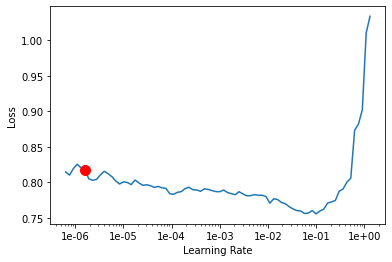

In [ ]:
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.623061,0.588267,0.661487,00:02
1,0.631066,0.593643,0.671476,00:02
2,0.628559,0.582975,0.695893,00:02
3,0.612257,0.587387,0.694784,00:02
4,0.610720,0.586489,0.697003,00:02


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

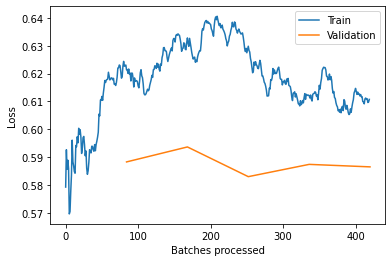

In [ ]:
learn_classifier.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


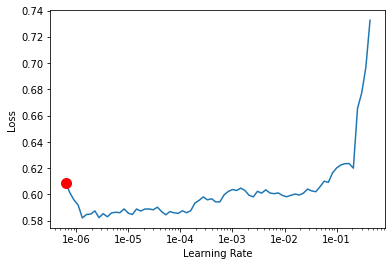

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
preds, targets = learn_classifier.get_preds()

predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,191,56
1,217,437
